# 1. Data preproccesing

### 1.1 Data reading

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import random
from tabulate import tabulate
import tqdm

In [72]:
data = pd.read_json('News_Category_Dataset_IS_course.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19


### 1.2 Understanding the data

All categories

In [73]:
categories = data.groupby('category').size().index.tolist()
categories

['BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'ENTERTAINMENT',
 'FOOD & DRINK',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'SPORTS',
 'STYLE & BEAUTY',
 'TRAVEL',
 'WELLNESS']

In [74]:
fig = go.Figure(
    data = [go.Bar(
        x=categories, 
        y=data.groupby('category').size().values,
        )],
    layout_title_text="All news categories distribution"
    
    )
fig.show()

Are there null elements?

In [75]:
data.isnull().sum()

link                   0
headline             731
category               0
short_description    736
authors                0
date                   0
dtype: int64

In [76]:
len(data[(data['short_description'].isnull()) & (data['headline'].isnull())])

0

Do the authors appear more than once

In [77]:
#do the authors appear more than once?  Yes
authors = data.groupby('authors').size().sort_values(ascending=False)
authors

authors
                                                                                                        24416
Lee Moran                                                                                                2058
Ron Dicker                                                                                               1726
Cole Delbyck                                                                                             1263
Reuters, Reuters                                                                                         1141
                                                                                                        ...  
Joe Peacock, Contributor\nAuthor, journalist, and troublemaker                                              1
Joe Peyronnin, Contributor\nHofstra Journalism Professor                                                    1
Andrew Burki, MSW, ContributorMacro Level Social Worker and CEO of Life of Purpose                          1
Jo

How many authors write for more than one category

In [197]:
authors = data.groupby('authors')['category'].nunique().sort_values(ascending=False) 
print(len(authors[authors>2]))
print(len(authors[authors==1]))

679
16913


### 1.3 Cleaning the data

#### 1.3.1 Simple cleaning

As we don't need link and date we drop them.

In [78]:
data = data.drop(['link', 'date'], axis=1)

Drop the null rows

In [79]:
data.dropna(subset=['headline', 'short_description'],inplace=True)

Resetting the index

In [80]:
data.reset_index(drop=True, inplace=True)

Combine headline and short_description and save it as text

In [81]:
#combine short_description and headline and author into one column
data['text'] = data['headline'] + ' ' + data['short_description'] + ' ' + data['authors']

#### 1.3.2 Text cleaning

Imports

In [82]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from IPython.display import clear_output

# Download necessary resources (if not already downloaded)
nltk.download('all')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

clear_output()

`clean_text` function transforms the text to lower case, separates the words as tokens, removes punctuations and stopwords and applies lemmatization.

In [83]:
def clean_text(text):

    # Transform to lower case
    text = text.lower()

    # Tokenization
    words = word_tokenize(text)

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    #can try stemming? mabye later

    # Join the words back into a string
    preprocessed_text = ' '.join(lemmatized_words)

    return preprocessed_text

In [84]:
data['clean_text'] = data['text'].apply(clean_text)

Example of `clean_text`

In [85]:
print(data.iloc[0]['text'])
print(data.iloc[0]['clean_text'])

23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don't understand what could be eaten." Elyse Wanshel
funniest tweet cat dog week dog understand could eaten elyse wanshel


Changing categories to numerical values

In [86]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(categories)

data['category'] = le.transform(data['category'])

### 1.4 Train, test split

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

# 2. Vectorization

## 2.1 TF-IDF

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer()  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
doc_index = 0

doc_vector = X_train_tfidf[doc_index]
doc_vector_array = doc_vector.toarray()

print(X_train.iloc[doc_index])

for i in range(len(doc_vector_array[0])):
    if doc_vector_array[0][i] > 0:
        print(doc_vector_array[0][i])

latest recalled dog food contain ingredient early december three pet food recall initiated due aflatoxin level acceptable limit karen becker contributor karen becker
0.21948488017542114
0.311045855324716
0.4086163061398898
0.21526512114591706
0.06665700004450488
0.19294271938513535
0.16273324569606967
0.17886780978473507
0.15746832248746986
0.2412579544135333
0.18547313398602977
0.26052083680869015
0.3618921930774932
0.1517938724728841
0.1615585506179658
0.18547313398602977
0.1876202015041393
0.19584682954568394
0.21948488017542114
0.14181632440052025


## 2.2 Word2Vec

Train Word2Vec model

In [23]:
from gensim.models import Word2Vec

# Tokenized text 
tokenized_train_text = [text.split() for text in X_train]
tokenized_test_text = [text.split() for text in X_test]

# Word2Vec parameters
vector_size = 100
window = 5
min_count = 1
epochs = 10

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_train_text, 
                    vector_size=vector_size, 
                    window=window, 
                    min_count=min_count, 
                    workers=4, 
                    epochs=epochs)

In [24]:
vocab_size = len(w2v_model.wv.key_to_index)

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 66785


In [25]:
def get_average_w2v(tokens):
    vector_sum = 0
    count = 0
    for word in tokens:
        if word in w2v_model.wv:
            vector_sum += w2v_model.wv[word]
            count += 1
    if count != 0:
        return vector_sum / count
    else:
        return [0] * 100 

# Add Word2Vec representations to DataFrame
X_train_w2v = [get_average_w2v(text) for text in tokenized_train_text]
X_test_w2v = [get_average_w2v(text) for text in tokenized_test_text]

# Convert to numpy arrays
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)

## 2.3 Sentence embeddings with BERT

In [89]:
from sentence_transformers import SentenceTransformer
import torch

Using Sentence Transformers library to calculate sentence embeddings for input texts

In [90]:
def embedding(texts):
    device = torch.device("cuda")
    model = SentenceTransformer('all-mpnet-base-v2').to(device)

    # Calculate embeddings
    embeddings = model.encode(texts)

    return embeddings

Calculate sentence embeddings for each text feature

In [91]:
# Get embeddings for the texts
short_desc_embeddings = embedding(data['short_description'])
headline_embeddings = embedding(data['headline'])
author_embeddings = embedding(data['authors'])


# Already calculated embeddings

# import pickle
# short_desc_path = 'short_desc_embeddings.pkl'
# headline_path = 'headline_embeddings.pkl'
# author_path = 'author_embeddings.pkl'

# with open(short_desc_path, 'rb') as f:
#     short_desc_embeddings = pickle.load(f)

# with open(headline_path, 'rb') as f:
#     headline_embeddings = pickle.load(f)

# with open(author_path, 'rb') as f:
#     author_embeddings = pickle.load(f)

Concatenate the vectors

In [92]:
X_bert = np.concatenate([short_desc_embeddings, headline_embeddings, author_embeddings], axis=1)
y_bert = data['category']

Train,test split

In [217]:
from sklearn.model_selection import train_test_split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

# Resampling

As the POLITICS has more then 35k news and the other ones have a lot less, we are dealing with imbalanced dataset.

In our case we will downsample as we already have a lot of data.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

In [27]:
fig = go.Figure(
    data = [go.Bar(
        x=categories, 
        y=y_train_res.value_counts().values,
        )],
    layout_title_text="All news categories distribution"
    
    )
fig.show()

# 3. Modeling

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

## 3.1 Average word2vec models

Initialize regression, random forest, KNN, XGBoost and LinearSVC models

In [29]:
avg_w2vec_logistic_model = LogisticRegression(max_iter=1000)
avg_w2vec_rf_model = RandomForestClassifier()
avg_w2vec_knn_model = KNeighborsClassifier(n_neighbors=1000)
avg_w2vec_xgb_model = XGBClassifier()
avg_w2vec_svc_model = LinearSVC()

Train models

In [30]:
print("Training Logistic Regression model...")
avg_w2vec_logistic_model.fit(X_train_w2v, y_train)
print("Training Random Forest model...")
avg_w2vec_rf_model.fit(X_train_w2v, y_train)
print("Training KNN model...")
avg_w2vec_knn_model.fit(X_train_w2v, y_train)
print("Training XGBoost model...")
avg_w2vec_xgb_model.fit(X_train_w2v, y_train)
print("Training Linear SVC model...")   
avg_w2vec_svc_model.fit(X_train_w2v, y_train)

Training Logistic Regression model...
Training Random Forest model...
Training KNN model...
Training XGBoost model...
Training Linear SVC model...


/usr/local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

## 3.2 TF-IDF models

In [31]:
tfidf_logistic_model = LogisticRegression(max_iter=1000)
tfidf_rf_model = RandomForestClassifier()
tfidf_knn_model = KNeighborsClassifier(n_neighbors=1000)
tfidf_xgb_model = XGBClassifier()
tfidf_svc_model = LinearSVC()

In [32]:
print("Training Logistic Regression model...")
tfidf_logistic_model.fit(X_train_tfidf, y_train)
print("Training Random Forest model...")
tfidf_rf_model.fit(X_train_tfidf, y_train)
print("Training KNN model...")
tfidf_knn_model.fit(X_train_tfidf, y_train)
print("Training XGBoost model...")
tfidf_xgb_model.fit(X_train_tfidf, y_train)
print("Training Linear SVC model...")
tfidf_svc_model.fit(X_train_tfidf, y_train)

Training Logistic Regression model...
Training Random Forest model...
Training KNN model...
Training XGBoost model...
Training Linear SVC model...


/usr/local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



LinearSVC()

## 3.3 TF-IDF Resampled

In [33]:
tfidf_re_logistic_model = LogisticRegression(max_iter=1000)
tfidf_re_rf_model = RandomForestClassifier()
tfidf_re_knn_model = KNeighborsClassifier(n_neighbors=1000)
tfidf_re_xgb_model = XGBClassifier()
tfidf_re_svc_model = LinearSVC()

In [34]:
print("Training Logistic Regression model...")
tfidf_re_logistic_model.fit(X_train_res, y_train_res)
print("Training Random Forest model...")
tfidf_re_rf_model.fit(X_train_res, y_train_res)
print("Training KNN model...")
tfidf_re_knn_model.fit(X_train_res, y_train_res)
print("Training XGBoost model...")
tfidf_re_xgb_model.fit(X_train_res, y_train_res)
print("Training Linear SVC model...")
tfidf_re_svc_model.fit(X_train_res, y_train_res)

Training Logistic Regression model...
Training Random Forest model...
Training KNN model...
Training XGBoost model...
Training Linear SVC model...


/usr/local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



LinearSVC()

## 3.4 Bert embeddings

In [94]:
bert_logistic_model = LogisticRegression(max_iter=1000)
bert_rf_model = RandomForestClassifier()
bert_knn_model = KNeighborsClassifier(n_neighbors=1000)
bert_xgb_model = XGBClassifier()
bert_svc_model = LinearSVC()

In [95]:
print("Training Logistic Regression model...")
bert_logistic_model.fit(X_train_bert, y_train_bert)
print("Training Random Forest model...")
bert_rf_model.fit(X_train_bert, y_train_bert)
print("Training KNN model...")
bert_knn_model.fit(X_train_bert, y_train_bert)
print("Training XGBoost model...")
bert_xgb_model.fit(X_train_bert, y_train_bert)
print("Training Linear SVC model...")
bert_svc_model.fit(X_train_bert, y_train_bert)

Training Logistic Regression model...
Training Random Forest model...
Training KNN model...
Training XGBoost model...
Training Linear SVC model...


/usr/local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



LinearSVC()

# 4. Model Evaluation

Confusion Matrix

In [127]:
def printNormalizedConfusionMatrix(model, X_test, y_test_label, categories):
    pred = model.predict(X_test)

    fig, ax = plt.subplots(figsize=(10, 10))
    confusion_matrix = metrics.confusion_matrix(y_test_label.tolist(), pred.tolist())
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=categories)
    cm_display.plot(ax=ax, values_format=".2f", cmap="Blues")

    # Customize text size and rotation on the bottom
    plt.xticks(rotation=90, ha='center', fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

Evaluate function

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

def evaluate_models(trained_models, X_test, y_test):
    """
    Evaluate the performance of multiple pre-trained text classification models.

    Parameters:
    - trained_models: Dictionary containing model names as keys and pre-trained model instances as values.
    - X_test, y_test: Testing data.

    Prints the evaluation metrics for each model in a tabulated format.
    """
    results = []
    headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

    best_model = None
    best_f1 = 0

    for model_name, model in tqdm.tqdm(trained_models.items()):
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics and round to the third decimal place
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=1), 3)
        recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
        f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
        

        # Append rounded results to the list
        results.append([model_name, accuracy, precision, recall, f1])

        # Update best model
        if f1 > best_f1:
            best_model = model
            best_f1 = f1

    
    # Print results in tabulated format
    print(tabulate(results, headers=headers, tablefmt="pretty"))
    return best_model, best_f1,results

# Example usage:
# trained_models = {'Logistic Regression': avg_logistic_model,
#                   'Random Forest': avg_rf_model,
#                   'SVM': avg_svm_model}
# evaluate_models(trained_models, X_test, y_test)

In [99]:
trained_models1 = {'Logistic Regression': tfidf_logistic_model,
                  'Random Forest': tfidf_rf_model,
                  'KNN (1000)': tfidf_knn_model,
                  'XGBoost': tfidf_xgb_model,
                  'Linear SVC': tfidf_svc_model}
trained_models2 = {'Logistic Regression': avg_w2vec_logistic_model,
                     'Random Forest': avg_w2vec_rf_model,
                     'KNN (1000)': avg_w2vec_knn_model,
                     'XGBoost': avg_w2vec_xgb_model,
                     'Linear SVC': avg_w2vec_svc_model}

trained_models3 = {'Logistic Regression': tfidf_re_logistic_model,
                  'Random Forest': tfidf_re_rf_model,
                  'KNN (1000)': tfidf_re_knn_model,
                  'XGBoost': tfidf_re_xgb_model,
                  'Linear SVC': tfidf_re_svc_model}

trained_models4 = {'Logistic Regression': bert_logistic_model,
                  'Random Forest': bert_rf_model,
                  'KNN (1000)': bert_knn_model,
                  'XGBoost': bert_xgb_model,
                  'Linear SVC': bert_svc_model}

In [100]:
print("TF-IDF")                 
best_tfidf, best_f1_tfidf,resultsTfIDf = evaluate_models(trained_models1, X_test_tfidf, y_test)
print("Word2Vec")
best_w2v, best_f1_w2v, resultsW2V = evaluate_models(trained_models2, X_test_w2v, y_test)
print("TF-IDF Resampled")
best_tfidf_re, best_f1_tfidf_re, resultsTfIDFRe = evaluate_models(trained_models3, X_test_tfidf, y_test)
print("BERT")
best_bert, best_f1_bert, resultsBERT = evaluate_models(trained_models4, X_test_bert, y_test_bert)

TF-IDF


100%|██████████| 5/5 [05:37<00:00, 67.53s/it] 


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.832   |   0.833   | 0.832  |  0.829   |
|    Random Forest    |   0.79   |   0.793   |  0.79  |  0.781   |
|     KNN (1000)      |  0.681   |   0.735   | 0.681  |  0.646   |
|       XGBoost       |  0.805   |   0.808   | 0.805  |  0.802   |
|     Linear SVC      |  0.847   |   0.845   | 0.847  |  0.845   |
+---------------------+----------+-----------+--------+----------+
Word2Vec


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.752   |   0.745   | 0.752  |  0.745   |
|    Random Forest    |  0.723   |   0.735   | 0.723  |   0.7    |
|     KNN (1000)      |  0.681   |   0.683   | 0.681  |  0.636   |
|       XGBoost       |  0.763   |   0.757   | 0.763  |  0.757   |
|     Linear SVC      |  0.739   |   0.731   | 0.739  |   0.72   |
+---------------------+----------+-----------+--------+----------+
TF-IDF Resampled


100%|██████████| 5/5 [02:43<00:00, 32.64s/it]


+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.796   |   0.818   | 0.796  |  0.802   |
|    Random Forest    |  0.747   |   0.785   | 0.747  |  0.755   |
|     KNN (1000)      |  0.667   |   0.712   | 0.667  |  0.673   |
|       XGBoost       |   0.77   |    0.8    |  0.77  |  0.778   |
|     Linear SVC      |  0.798   |   0.82    | 0.798  |  0.803   |
+---------------------+----------+-----------+--------+----------+
BERT


100%|██████████| 5/5 [03:34<00:00, 42.81s/it]

+---------------------+----------+-----------+--------+----------+
|        Model        | Accuracy | Precision | Recall | F1-Score |
+---------------------+----------+-----------+--------+----------+
| Logistic Regression |  0.855   |   0.853   | 0.855  |  0.853   |
|    Random Forest    |  0.783   |   0.811   | 0.783  |  0.769   |
|     KNN (1000)      |  0.742   |   0.763   | 0.742  |  0.714   |
|       XGBoost       |   0.86   |   0.86    |  0.86  |  0.857   |
|     Linear SVC      |  0.862   |   0.86    | 0.862  |  0.859   |
+---------------------+----------+-----------+--------+----------+


Print the confusion matrix for the best model

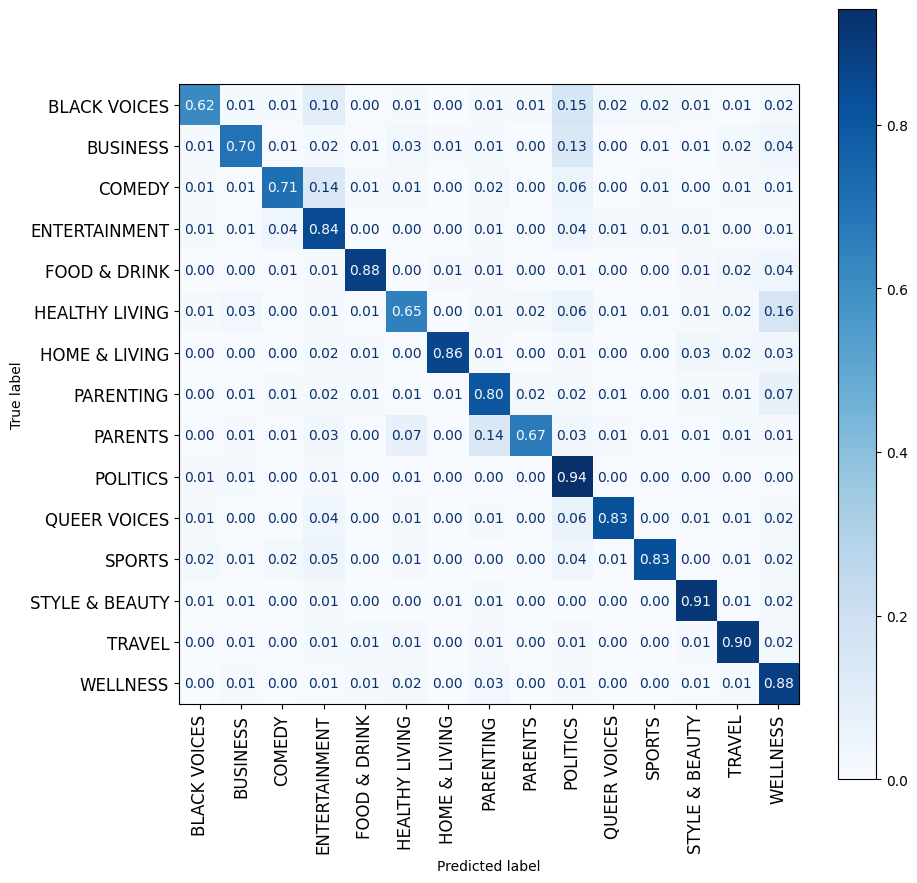

In [126]:
#chose the best model from f1 score
max_f1 = max(best_f1_tfidf, best_f1_w2v, best_f1_tfidf_re)

if max_f1 == best_f1_tfidf:
    best_model = best_tfidf
elif max_f1 == best_f1_w2v:
    best_model = best_w2v
elif max_f1 == best_f1_tfidf_re:
    best_model = best_tfidf_re
else:
    best_model = best_bert

printNormalizedConfusionMatrix(best_model, X_test_tfidf, y_test, categories)


# DistilBERT

### Imports

In [102]:
import time
import pandas as pd
import requests
import torch
import torch.nn.functional as F

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

### Train, validation and test split

In [103]:
torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS = 3

In [206]:
X_train, X_test, y_train, y_test = train_test_split(data[['clean_text']], data['category'], test_size=0.25, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Tokenizer

We download the pretrained tokenizer from distilbert.

In [105]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(X_train['clean_text']), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid['clean_text']), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test['clean_text']), truncation=True, padding=True)

Tokenizer testing

In [106]:
first_sentence = X_train['clean_text'].iloc[0]

# Tokenize the first sentence
encoding = tokenizer(first_sentence, truncation=True, padding=True, return_tensors='np')

# Print words, token IDs, and attention mask
words = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
token_ids = encoding['input_ids'][0]
attention_mask = encoding['attention_mask'][0]

print("Words:", words)
print("Token IDs:", token_ids)
print("Attention Mask:", attention_mask)

Words: ['[CLS]', 'power', 'know', 'day', 'long', 'day', 'day', 'child', 'turning', 'u', 'question', 'seeking', 'information', 'wisdom', 'guidance', 'sometimes', 'pest', '##ering', 'u', 'stall', '##ing', 'bed', '##time', 'natural', 'role', 'u', 'natural', 'role', 'truth', 'answer', 'car', '##issa', 'k', 'contributor', 'mother', 'writer', '[SEP]']
Token IDs: [  101  2373  2113  2154  2146  2154  2154  2775  3810  1057  3160  6224
  2592  9866  8606  2823 20739  7999  1057 13498  2075  2793  7292  3019
  2535  1057  3019  2535  3606  3437  2482 21205  1047 12130  2388  3213
   102]
Attention Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Dataset and Dataloader

In [107]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(int)

    def __getitem__(self, idx):
        try:
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise

    def __len__(self):
        return len(self.labels)


train_dataset = NewsDataset(train_encodings, y_train)
valid_dataset = NewsDataset(valid_encodings, y_valid)
test_dataset = NewsDataset(test_encodings, y_test)

In [108]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model

Model initialization

In [141]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=15)
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Testing

In [110]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [111]:
def train_model(model, train_loader, valid_loader, NUM_EPOCHS, device, optim):
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        
        for batch_idx, batch in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            
            # Prepare data
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            # Forward
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']
            
            # Backward
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            ### Logging
            if not batch_idx % 250:
                print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                    f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                    f'Loss: {loss:.4f}')


        model.eval()

        with torch.set_grad_enabled(False):

            valid_accuracy = compute_accuracy(model, valid_loader, DEVICE)

            print(f'\nvalid accuracy: '
                        f'{valid_accuracy:.2f}%')           

As we have already trained the model, we do not train it.

In [112]:
model.train()
train_model(model, train_loader, valid_loader, NUM_EPOCHS, DEVICE, optim)

#already trained model
#model.load_state_dict(torch.load("distilBERT.pth", map_location=torch.device('cpu')))

### Evaluation

Function classify returns a numpy array of shape (len(X), 15) where each row is a probability distribution over the 15 classes.

In [113]:
def classify(model, X,device):
  with torch.no_grad():

    predictions = []

    for i in tqdm.tqdm(range(len(X)), total=len(X)):
      sentance = X['clean_text'][i]
      sentance = tokenizer(sentance, truncation=True, padding=True)

      output = model(torch.tensor(sentance['input_ids']).unsqueeze(0).to(DEVICE), torch.tensor(sentance['attention_mask']).unsqueeze(0).to(DEVICE))
      softmax = F.softmax(output.logits, dim=1).cpu().numpy()

      predictions.append(softmax)

  predictions = np.array(predictions)
  predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])

  return predictions

In [114]:
model.eval()
predicitons = classify(model, X_test, DEVICE)

#f1 score
from sklearn.metrics import f1_score

print(f1_score(y_test, np.argmax(predicitons, axis=1), average='weighted'))


100%|██████████| 18332/18332 [10:50<00:00, 28.20it/s]

0.8760840637191332


In [218]:
model_name = "DistilBERT"
results = []
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

y_pred = np.argmax(predicitons, axis=1)

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=1), 3)
recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)

results.append([model_name, accuracy, precision, recall, f1])

print(tabulate(results, headers=headers, tablefmt="pretty"))

+------------+----------+-----------+--------+----------+
|   Model    | Accuracy | Precision | Recall | F1-Score |
+------------+----------+-----------+--------+----------+
| DistilBERT |  0.876   |   0.877   | 0.876  |  0.876   |
+------------+----------+-----------+--------+----------+


Confusion matrix

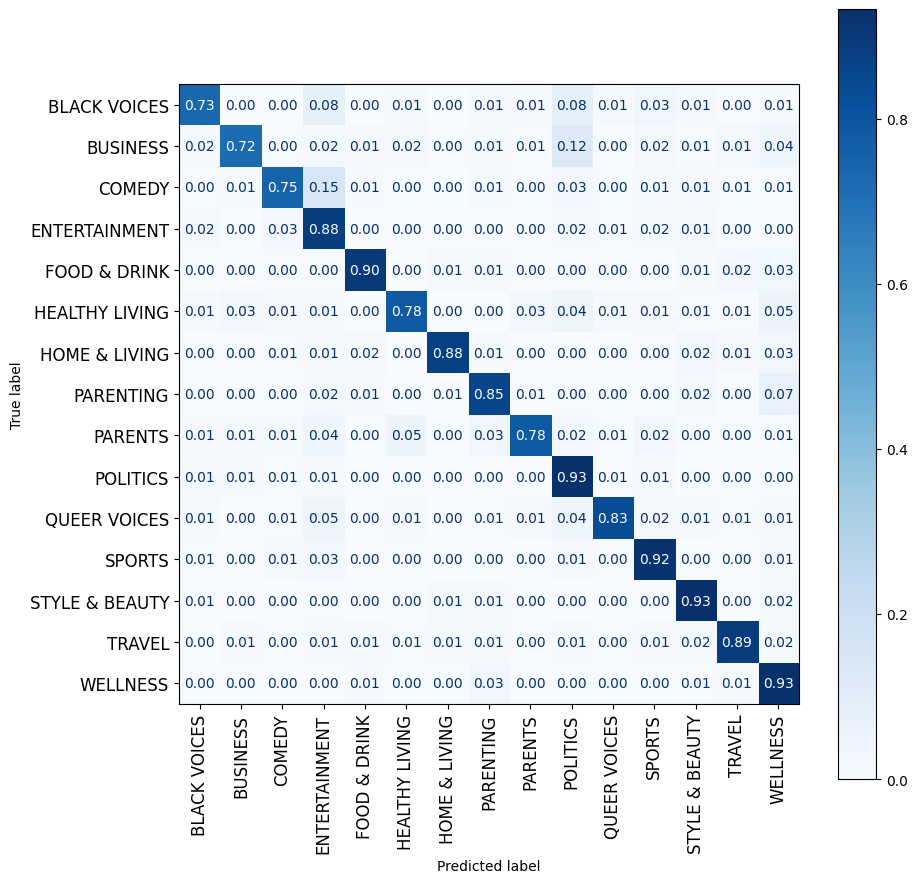

In [131]:
pred = np.argmax(predicitons, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = metrics.confusion_matrix(y_test.tolist(), pred.tolist())
normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_matrix, display_labels=categories)
cm_display.plot(ax=ax, values_format=".2f", cmap="Blues")
# Customize text size and rotation on the bottom
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.show()